In [1]:
import pandas as pd 
import numpy as np 
from scipy.signal import butter, filtfilt, iirnotch
import scipy.signal as signal
import matplotlib.pyplot as plt
from datetime import datetime
import os

## Compute metrics

In [111]:
def filter_data(data, fs=250, notch_f0 = 60, Q = 100):
  nyq = 0.5*fs
  # remove dc offset 
  b,a = butter(2, 1/nyq, 'highpass')
  y = filtfilt(b,a,data)

  b_notch, a_notch = iirnotch(notch_f0, Q, fs)
  y = filtfilt(b_notch, a_notch, y)

  return y

In [112]:
import warnings
warnings.filterwarnings('ignore')
import os 
from src.analyze.emg_processing import analyzeEMG

############### Change group here ############### 
data_dir = './openbci-data/g20/'
save_dir = './openbci-data/results/g20/'

for subdir, dirs, files in os.walk(data_dir):
    # print(subdir)
    counter = 0
    for file in files: 
        print(subdir, file)
        if os.path.join(subdir, file).endswith('csv'): 
            save_td_filepath = f'td_{subdir[-2:]}.csv'
            save_fd_filepath = f'fd_{subdir[-2:]}.csv'
            
            df = pd.read_table(subdir+'/'+file, header=None)
            data = df[1][250:-250] ## first 2 and last 2 seconds excluded
            middle_ind = int((len(data) - 1)/2)
            data = data[middle_ind-250:middle_ind+250] ## then only take middle 2 secs for processing
            y = filter_data(data)
            # print(y)
            result_dict = analyzeEMG(y, 250, False)
            
            df_td = pd.DataFrame(result_dict['TimeDomain'], index=[0])
            df_fd = pd.DataFrame(result_dict['FrequencyDomain'], index=[0])
            df_td['File'] = file[-8:-4]
            df_fd['File'] = file[-8:-4]

            if counter == 0: 
                df_td.to_csv((save_dir+save_td_filepath), index=False, mode='a');
                df_fd.to_csv((save_dir+save_fd_filepath), index=False, mode='a');
            else: 
                df_td.to_csv((save_dir+save_td_filepath), index=False, header=False, mode='a');
                df_fd.to_csv((save_dir+save_fd_filepath), index=False, header=False, mode='a');
        counter += 1

./openbci-data/g20/ .DS_Store
./openbci-data/g20/g20_U6 OpenBCI-RAW-2023-02-28_15-54-40.txt
./openbci-data/g20/g20_U6 BrainFlow-RAW_2023-02-28_15-48-10_3_80_1.csv
./openbci-data/g20/g20_U6 BrainFlow-RAW_2023-02-28_15-48-10_1_100_1.csv
./openbci-data/g20/g20_U6 .DS_Store
./openbci-data/g20/g20_U6 OpenBCI-RAW-2023-02-28_15-53-58.txt
./openbci-data/g20/g20_U6 OpenBCI-RAW-2023-02-28_15-52-33.txt
./openbci-data/g20/g20_U6 BrainFlow-RAW_2023-02-28_15-48-10_7_50_2.csv
./openbci-data/g20/g20_U6 BrainFlow-RAW_2023-02-28_15-48-10_9_20_2.csv
./openbci-data/g20/g20_U6 OpenBCI-RAW-2023-02-28_15-50-52.txt
./openbci-data/g20/g20_U6 BrainFlow-RAW_2023-02-28_15-48-10_8_20_1.csv
./openbci-data/g20/g20_U6 BrainFlow-RAW_2023-02-28_15-48-10_4_80_2.csv
./openbci-data/g20/g20_U6 BrainFlow-RAW_2023-02-28_15-48-10_11_10_2.csv
./openbci-data/g20/g20_U6 OpenBCI-RAW-2023-02-28_15-51-33.txt
./openbci-data/g20/g20_U6 BrainFlow-RAW_2023-02-28_15-48-10_10_10_1.csv
./openbci-data/g20/g20_U6 OpenBCI-RAW-2023-02-28_15-5

## Get averages

In [113]:
save_dir

'./openbci-data/results/g20/'

In [114]:
df_list = []
exp_list = []
for subdir, dirs, files in os.walk(save_dir):
    for file in files: 
        if os.path.join(subdir, file).endswith('csv'):
            df = pd.read_csv(os.path.join(subdir, file)) 
            df_list.append(df)
            exp_list.append(file[:-4]) 

In [115]:
len(df_list), len(exp_list)

(16, 16)

In [116]:
# df_list = [df_tdres]
# exp_list = ['td_U1']

mvc_levels = ['10', '20','50','80', '00']
mean_rows = ['10-mean', '20-mean', '50-mean', '80-mean', '100-mean']

In [117]:
for df in df_list: 
    for mvc in mvc_levels: 
        if mvc == '00': 
            row_name = '100-mean'
        else: 
            row_name = mvc+'-mean'
        df.loc[row_name] = df[df['File'].str.contains(mvc, na=False)].mean(numeric_only=True, axis=0,skipna=True)
        df.at[row_name, 'File'] = row_name 

In [118]:
for i,df in enumerate(df_list): 
    df_means = df[df.index.isin(mean_rows)]
    df_means.to_csv(save_dir+exp_list[i]+'.csv', index=False)

After this step, the files within save_dir are all the mean results computed from 2 collected trials. 

Now, **manually split the results into TD and FD to compute group means. 

## TD/FD mean of each group

In [124]:
dir = './openbci-data/results/g20/fd/'

## manually change the dirs to get TD/FD means of a group

In [125]:
df_list = []
exp_list = []
for subdir, dirs, files in os.walk(dir):
    for file in files: 
        if os.path.join(subdir, file).endswith('csv'):
            df = pd.read_csv(os.path.join(subdir, file)) 
            df_list.append(df)
            exp_list.append(file[:-4]) 

In [126]:
df_all = pd.concat(df_list, ignore_index=True)

In [127]:
mean_rows = ['10-mean', '20-mean', '50-mean', '80-mean', '100-mean']
target_indices = []

df = df_all

for mean_row in mean_rows: 
    index = mean_row+'-all'
    target_indices.append(index)
    df.loc[index] = df[df['File'].str.contains(mean_row, na=False)].mean(numeric_only=True, axis=0,skipna=True)
    df.at[index, 'File'] = index 

In [128]:
df_means_all = df[df.index.isin(target_indices)]
df_means_all.to_csv(dir+'all_users_means.csv', index=False)

## Get Plots to compare the 2 groups

In [129]:
df_20_td = pd.read_csv('./openbci-data/results/g20/td/all_users_means.csv')
df_20_fd = pd.read_csv('./openbci-data/results/g20/fd/all_users_means.csv')
df_50_td = pd.read_csv('./openbci-data/results/g50/td/all_users_means.csv')
df_50_fd = pd.read_csv('./openbci-data/results/g50/fd/all_users_means.csv')

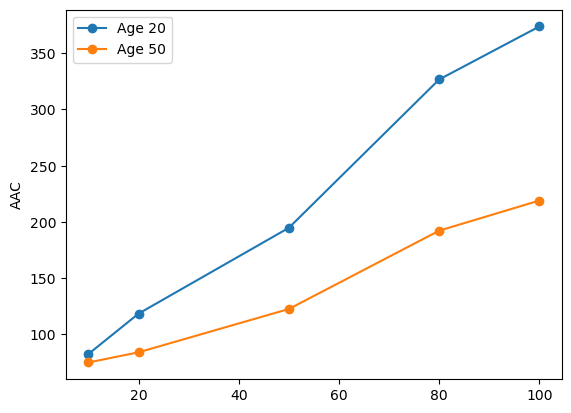

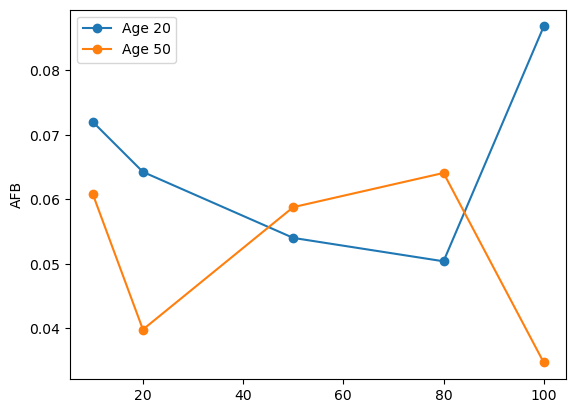

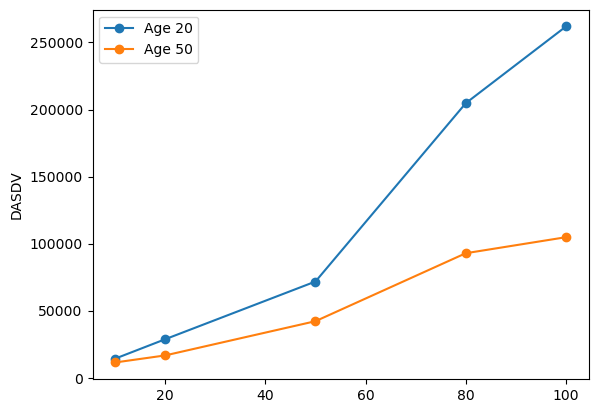

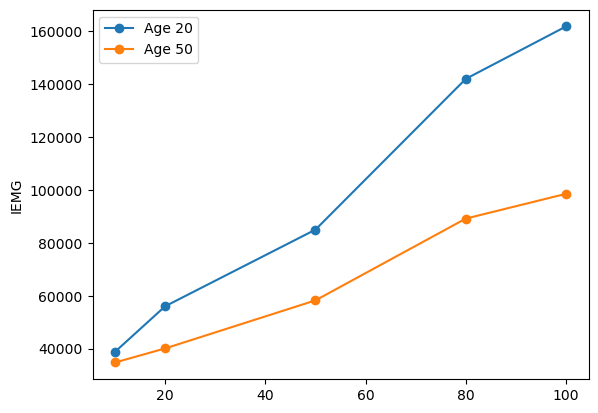

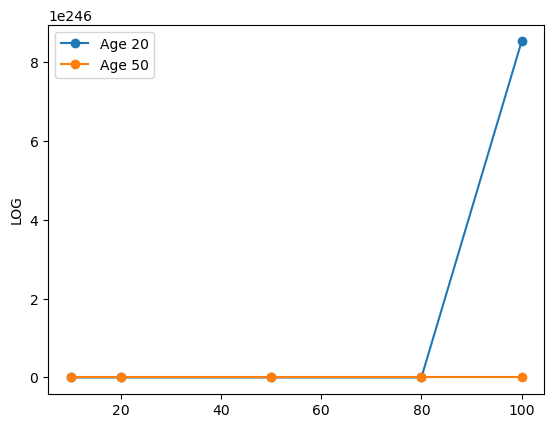

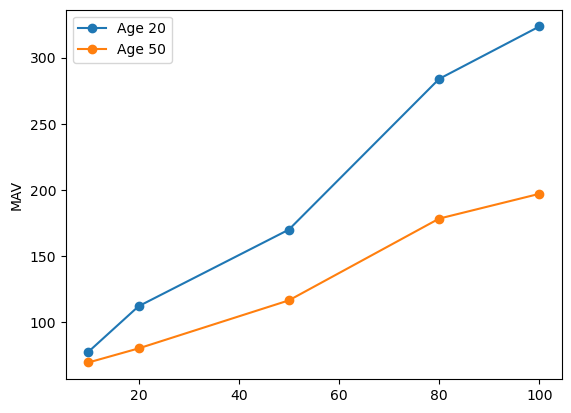

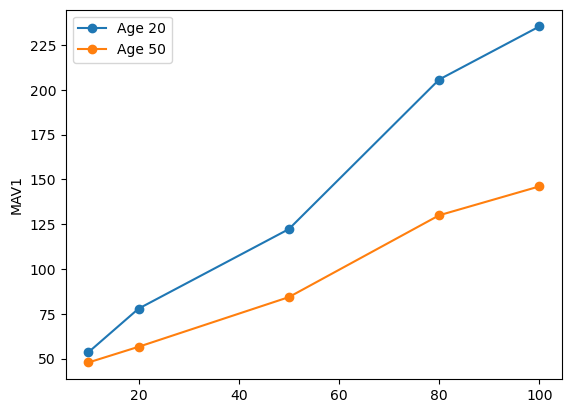

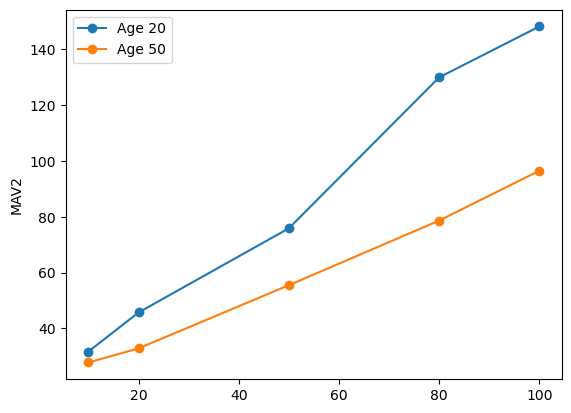

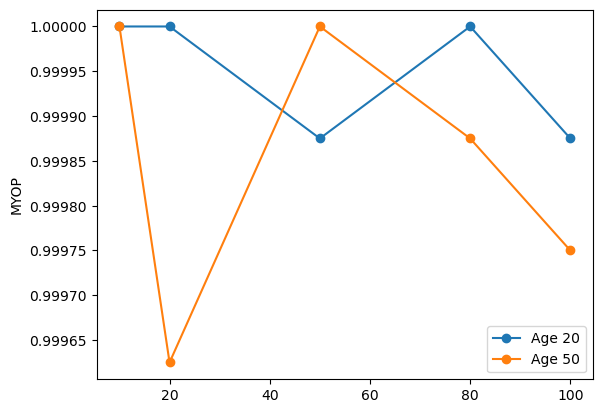

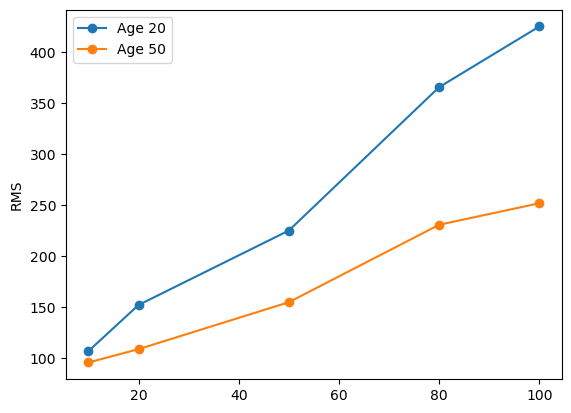

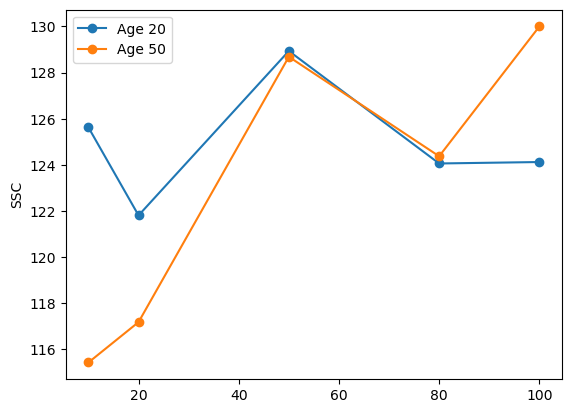

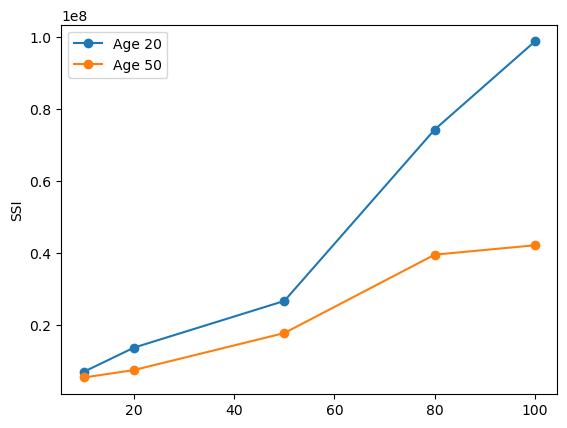

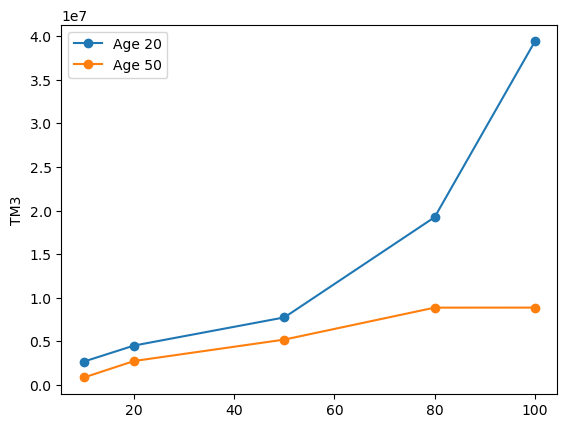

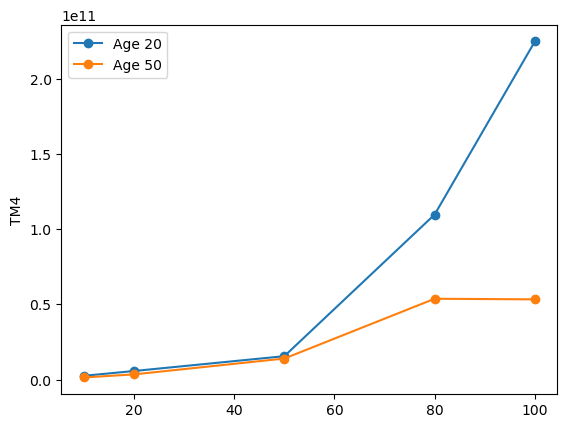

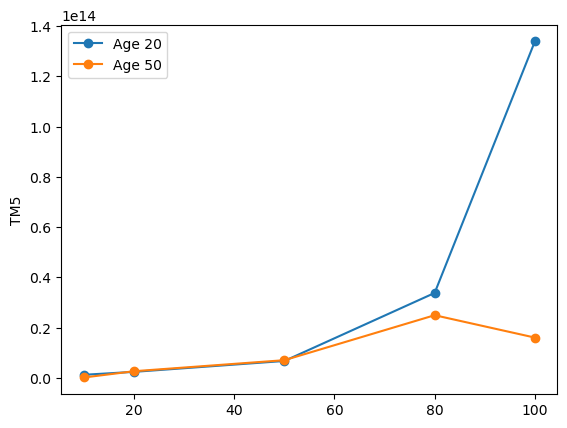

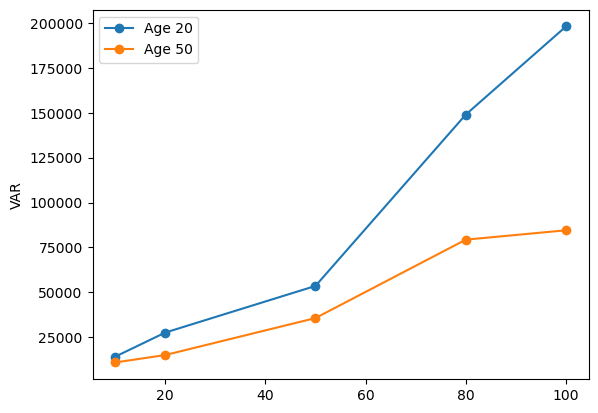

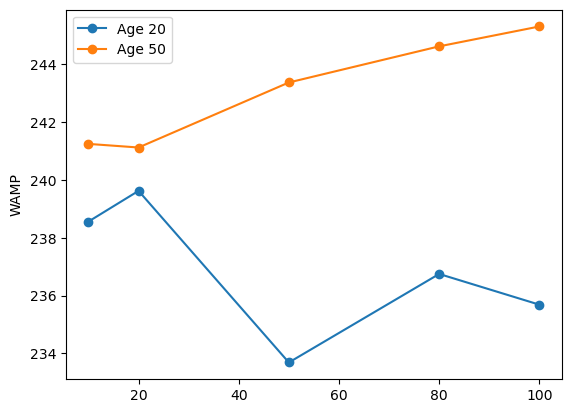

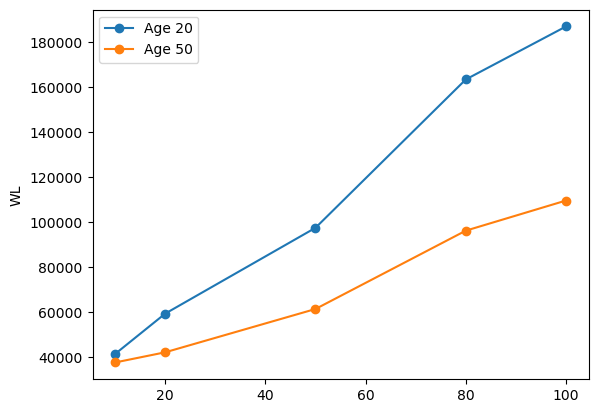

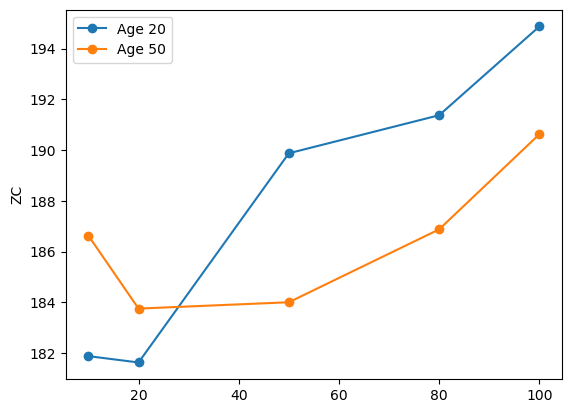

In [130]:
from matplotlib import pyplot as plt
%matplotlib inline

mvc_perc = [10, 20, 50, 80, 100]

cols = df_20_td.columns.difference(['File'])
for col in cols: 
    plt.figure()
    # print(len(data[col].tolist()))
    plt.plot(mvc_perc, df_20_td[col].tolist(), marker='o', label='Age 20') 
    plt.plot(mvc_perc, df_50_td[col].tolist(), marker='o', label='Age 50') 
    plt.ylabel(col)
    plt.legend()
    plt.show()

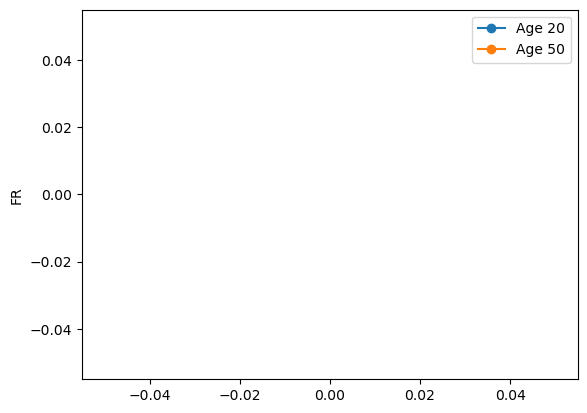

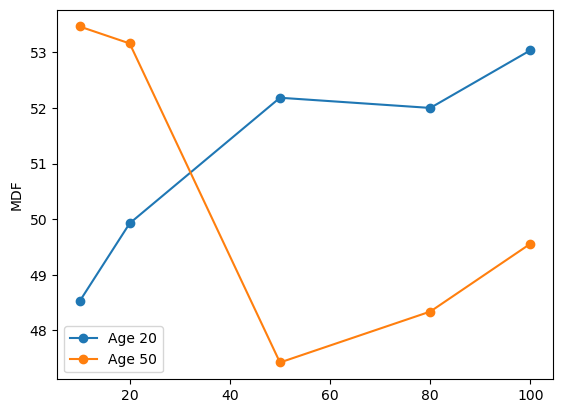

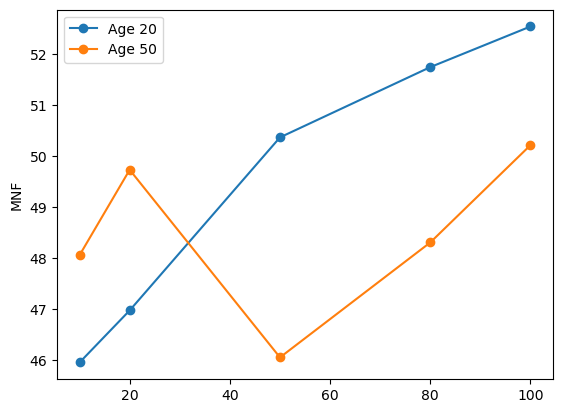

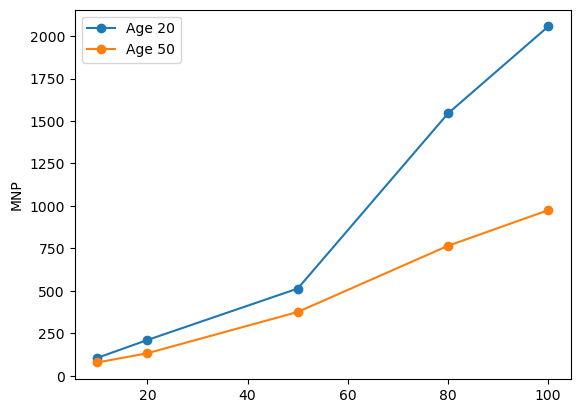

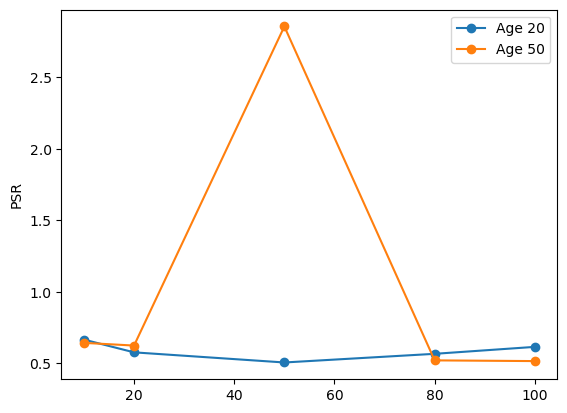

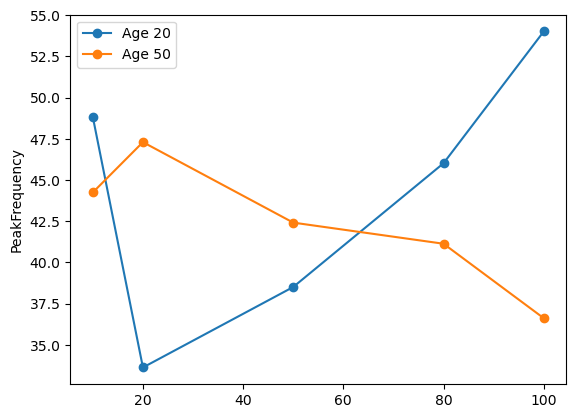

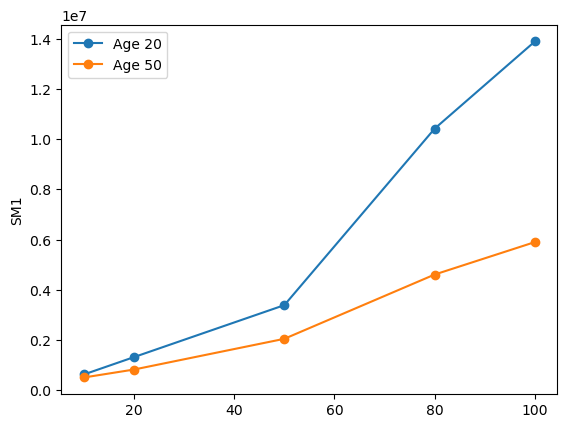

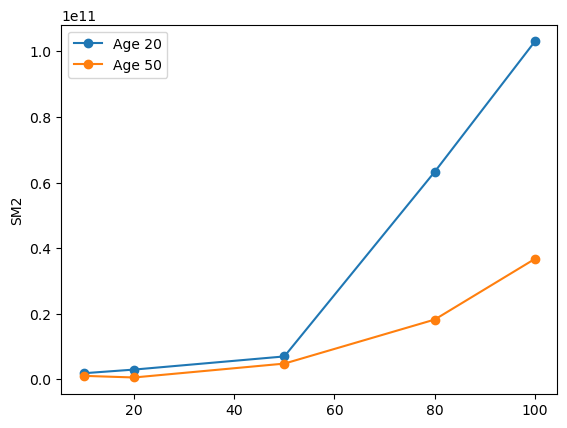

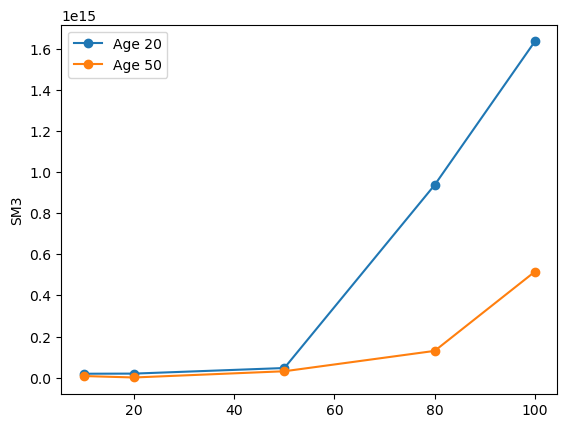

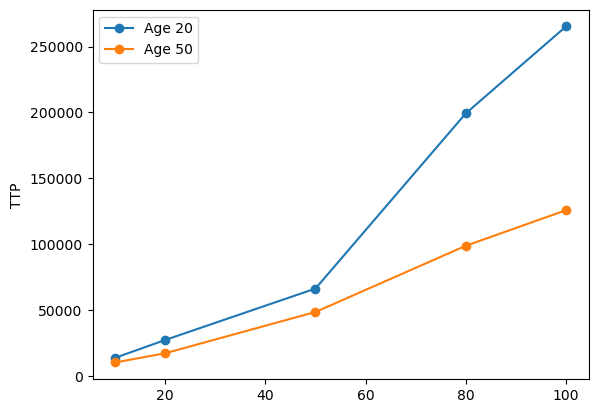

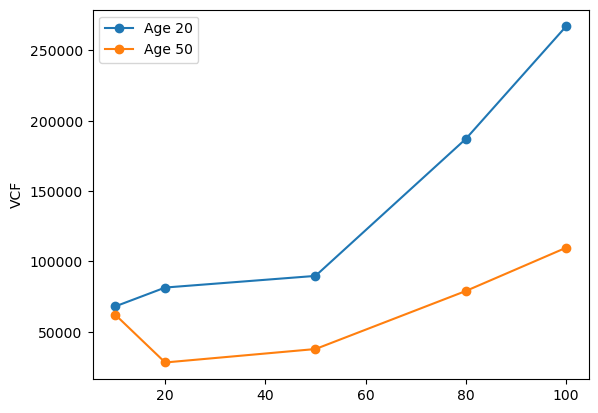

In [131]:
from matplotlib import pyplot as plt
%matplotlib inline

mvc_perc = [10, 20, 50, 80, 100]

cols = df_20_fd.columns.difference(['File'])
for col in cols: 
    plt.figure()
    # print(len(data[col].tolist()))
    plt.plot(mvc_perc, df_20_fd[col].tolist(), marker='o', label='Age 20') 
    plt.plot(mvc_perc, df_50_fd[col].tolist(), marker='o', label='Age 50') 
    plt.ylabel(col)
    plt.legend()
    plt.show()

## In Group variations

In [137]:
data_dir = './openbci-data/results/g20/td/'

In [138]:
df_list = []
exp_list = []
for subdir, dirs, files in os.walk(data_dir):
    for file in files: 
        if os.path.join(subdir, file).endswith('csv') and 'td' in file:
            df = pd.read_csv(os.path.join(subdir, file)) 
            df_list.append(df)
            exp_list.append(file[:-4]) 

In [139]:
exp_list

['td_U8', 'td_U4', 'td_U5', 'td_U7', 'td_U6', 'td_U2', 'td_U3', 'td_U1']

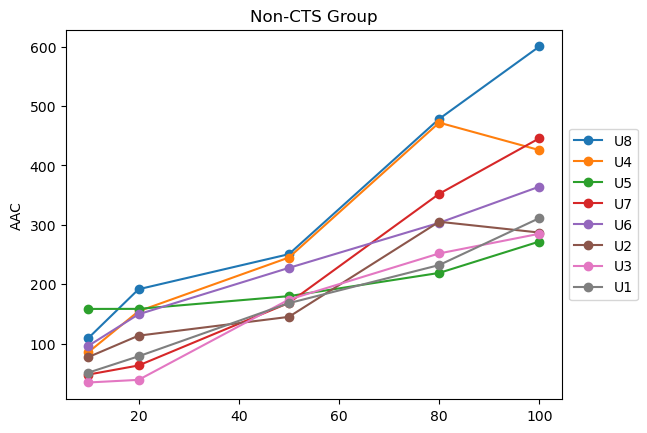

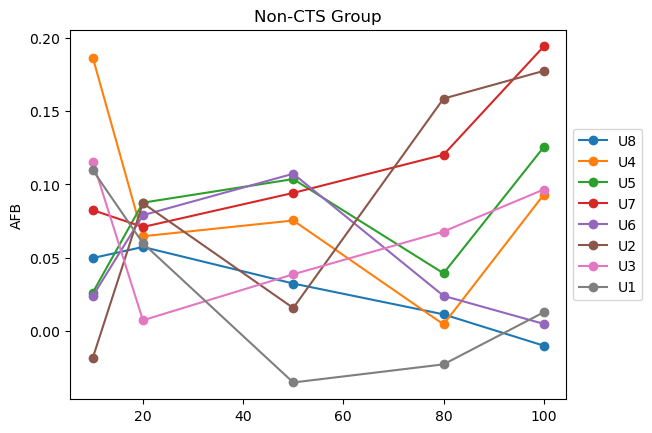

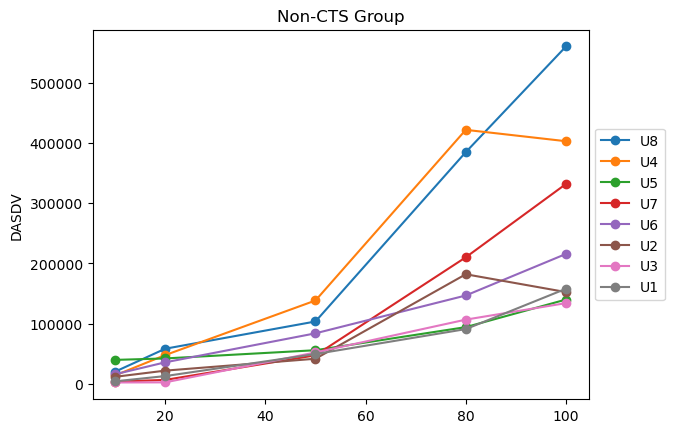

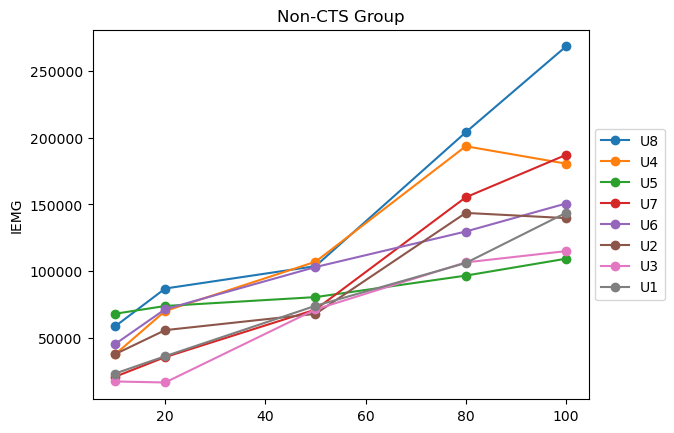

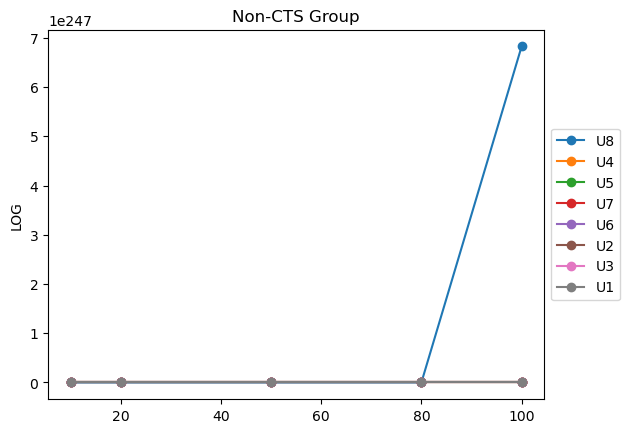

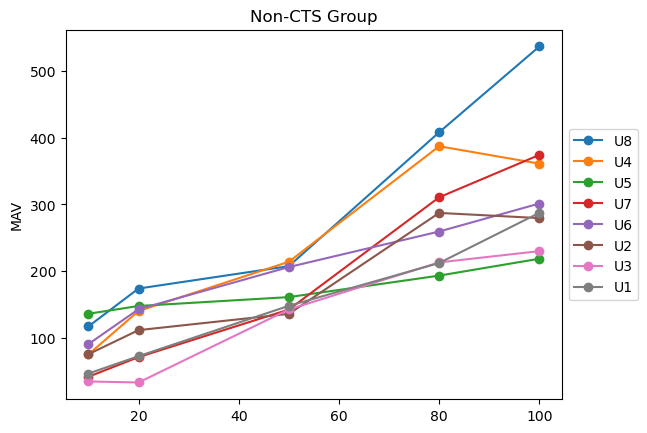

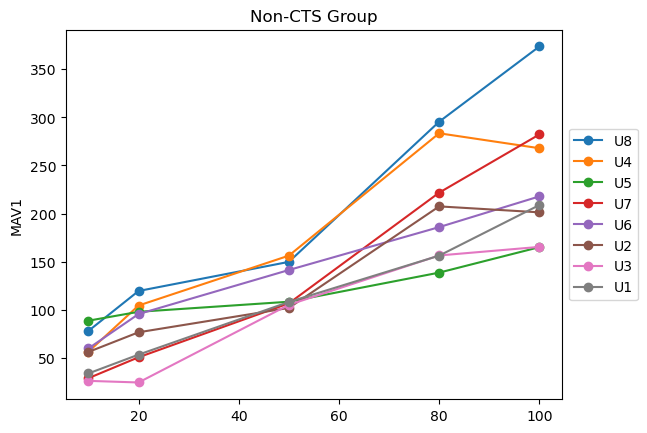

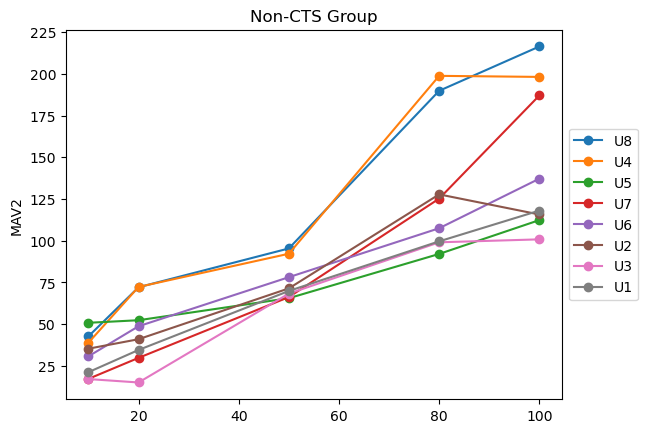

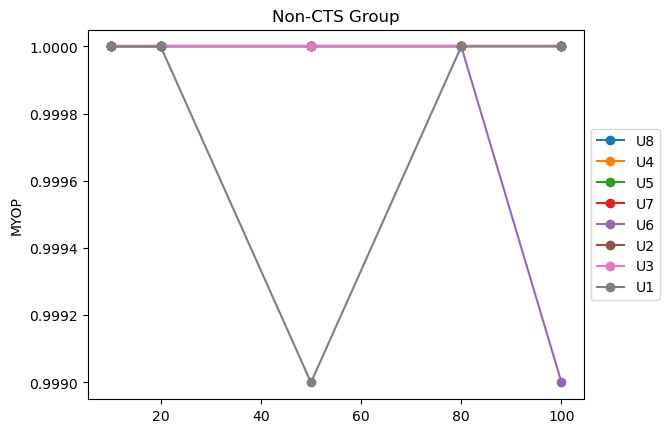

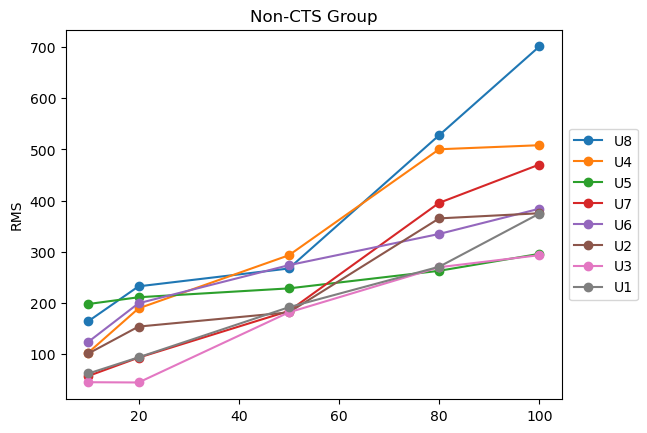

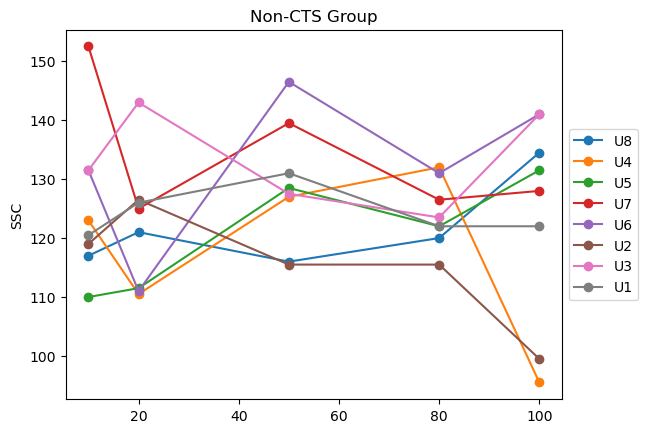

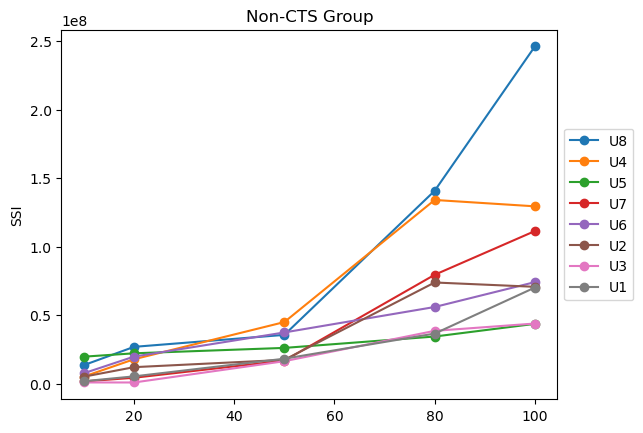

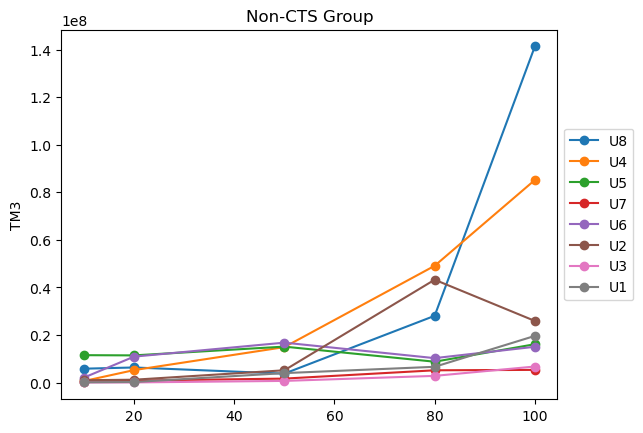

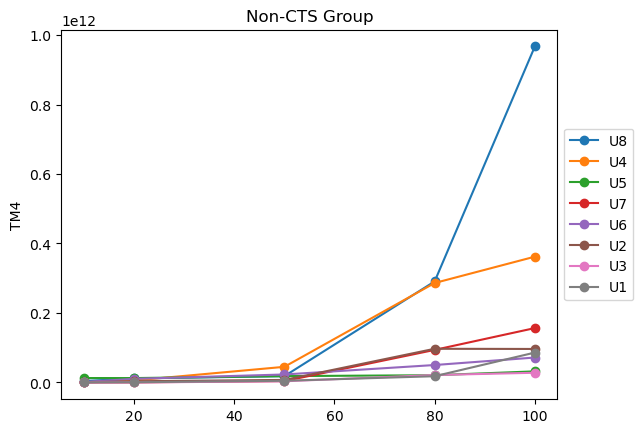

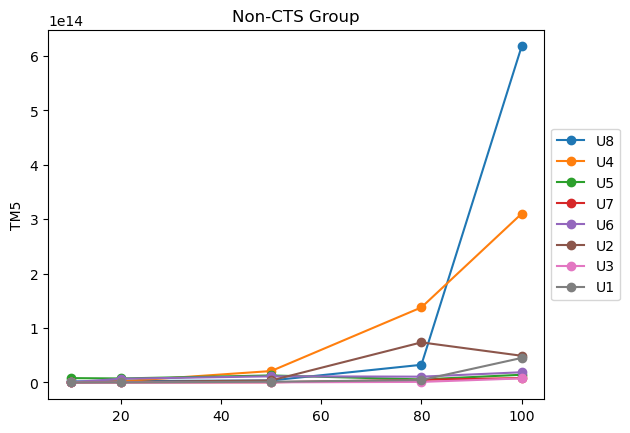

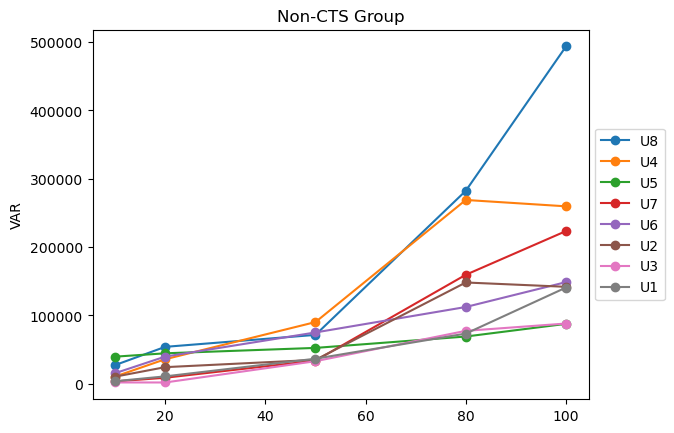

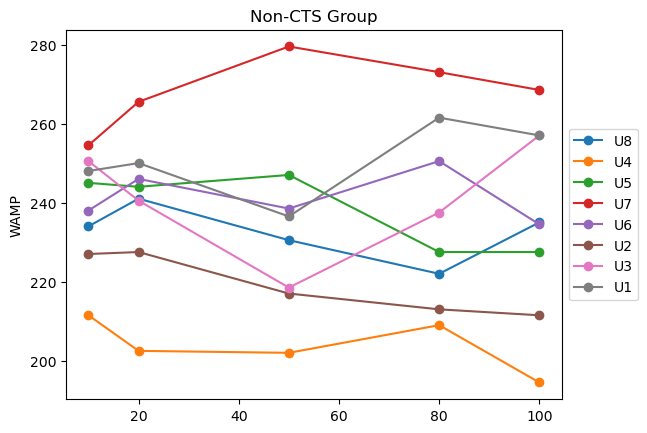

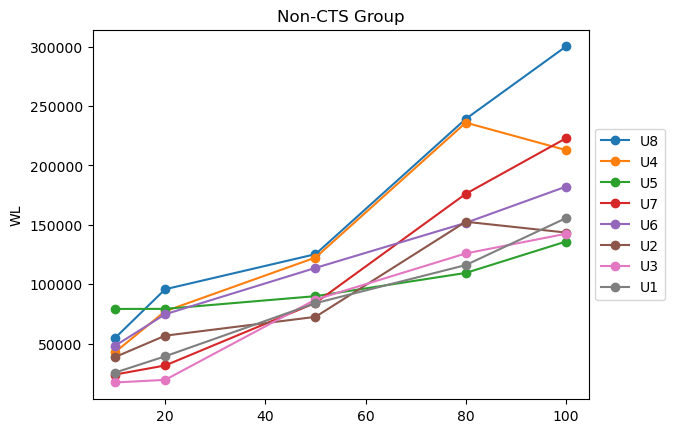

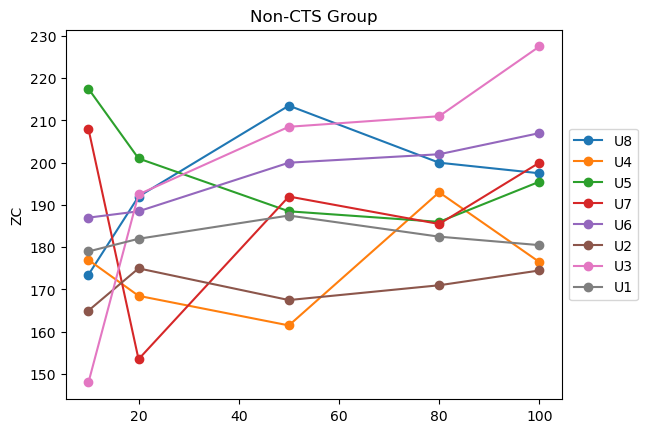

In [146]:
mvc_perc = [10, 20, 50, 80, 100]

cols = df_list[0].columns.difference(['File'])
for col in cols: 
    plt.figure()
    for i,df in enumerate(df_list): 
        plt.plot(mvc_perc, df[col].tolist(), marker='o', label=exp_list[i][-2:]) 
    plt.ylabel(col)
    plt.title("Non-CTS Group")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

['fd_U6', 'fd_U7', 'fd_U5', 'fd_U4', 'fd_U1', 'fd_U3', 'fd_U2', 'fd_U8']


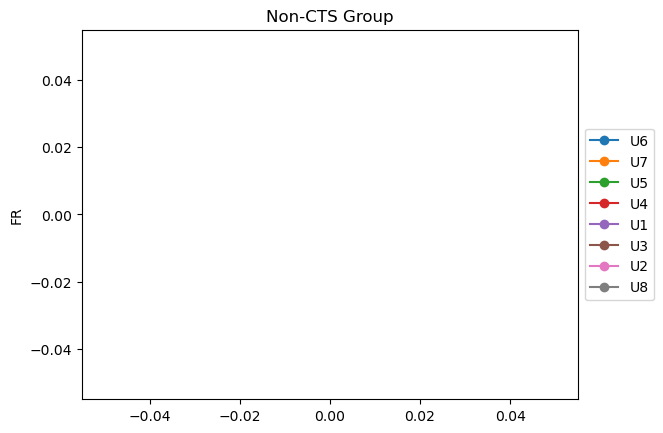

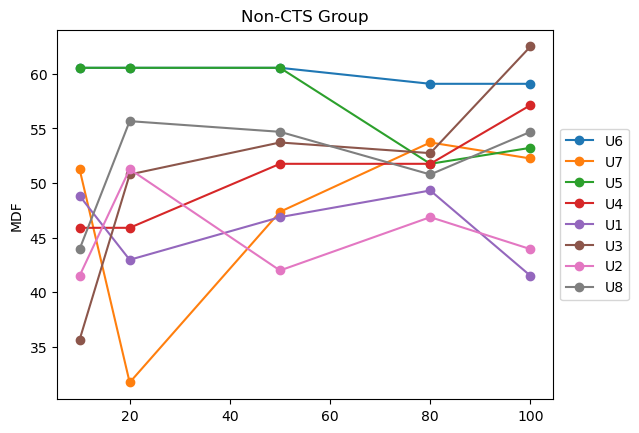

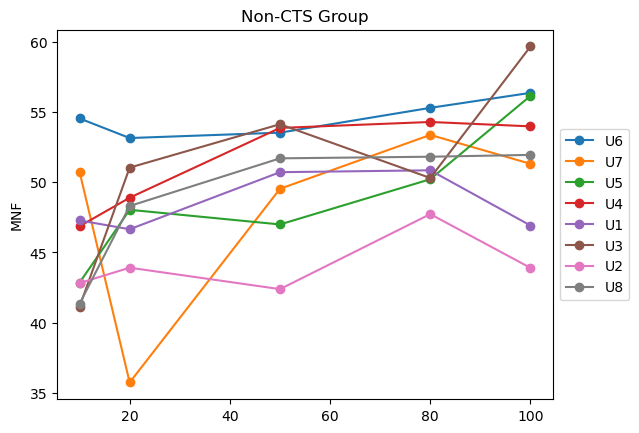

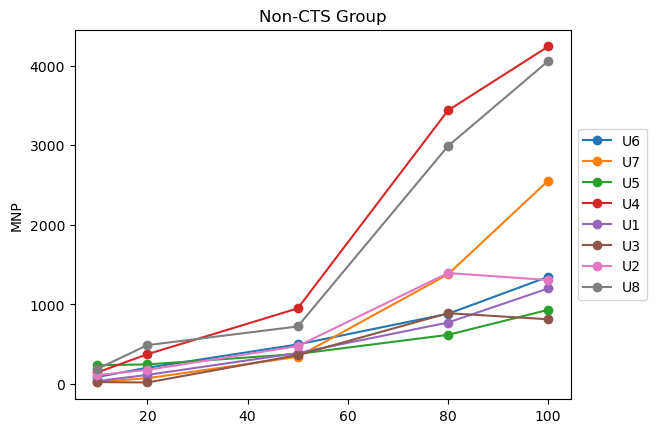

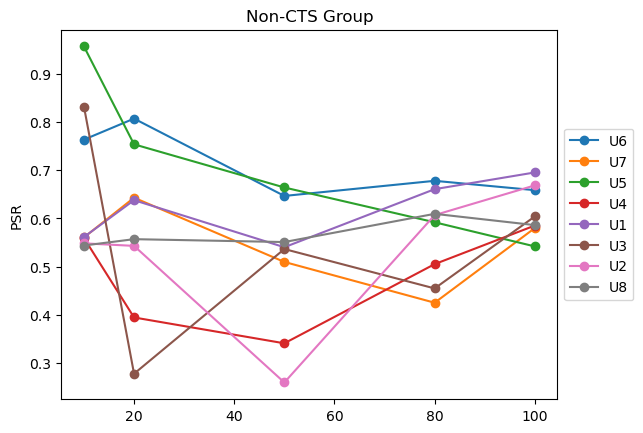

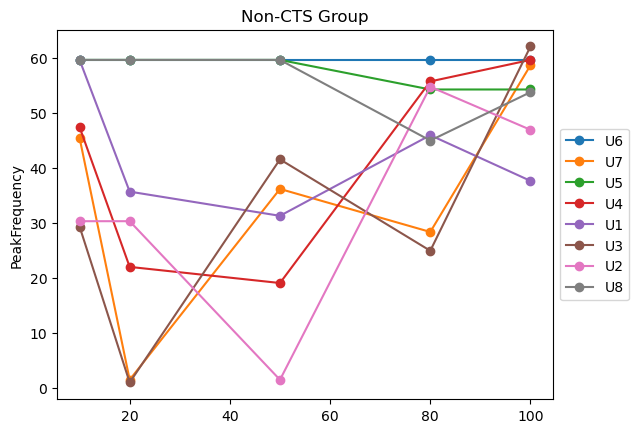

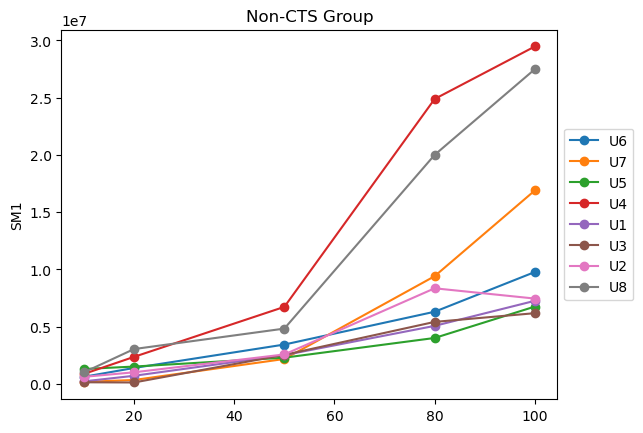

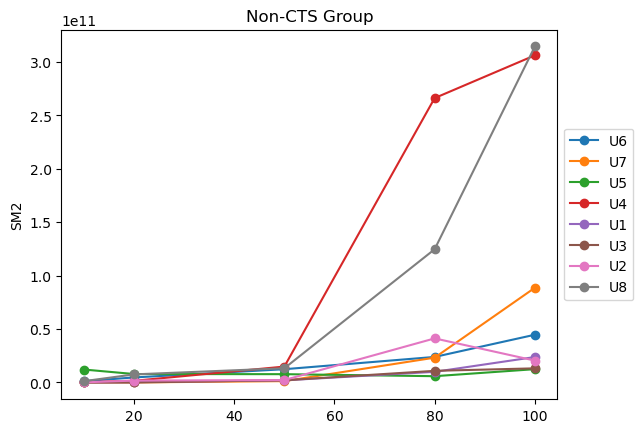

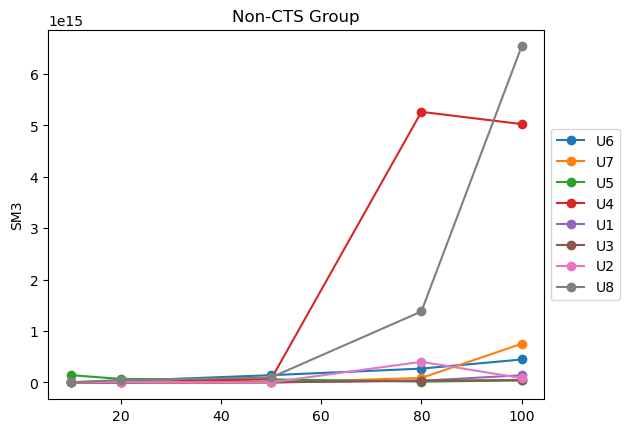

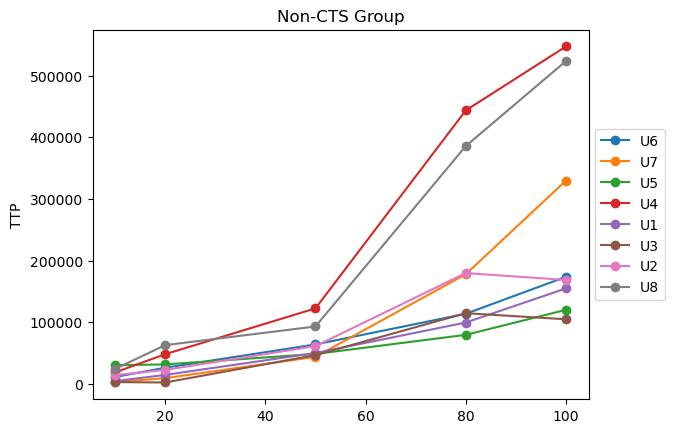

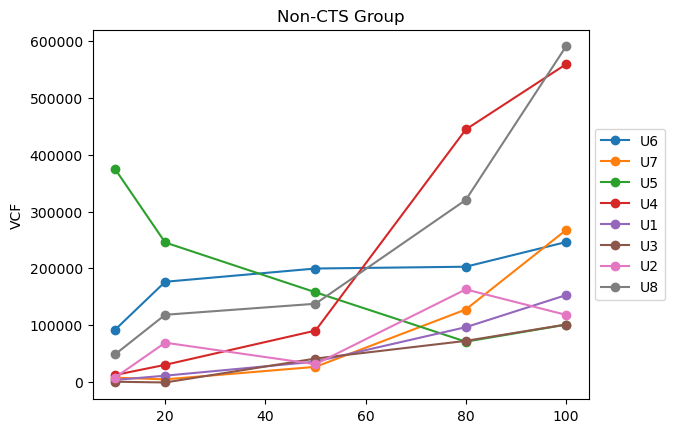

In [148]:
## Frequency domain G20
data_dir = './openbci-data/results/g20/fd/'

df_list = []
exp_list = []
for subdir, dirs, files in os.walk(data_dir):
    for file in files: 
        if os.path.join(subdir, file).endswith('csv') and 'fd' in file:
            df = pd.read_csv(os.path.join(subdir, file)) 
            df_list.append(df)
            exp_list.append(file[:-4]) 

print(exp_list)

mvc_perc = [10, 20, 50, 80, 100]

cols = df_list[0].columns.difference(['File'])
for col in cols: 
    plt.figure()
    for i,df in enumerate(df_list): 
        plt.plot(mvc_perc, df[col].tolist(), marker='o', label=exp_list[i][-2:]) 
    plt.ylabel(col)
    plt.title("Non-CTS Group")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

['td_U8', 'td_U4', 'td_U5', 'td_U7', 'td_U6', 'td_U2', 'td_U3', 'td_U1']


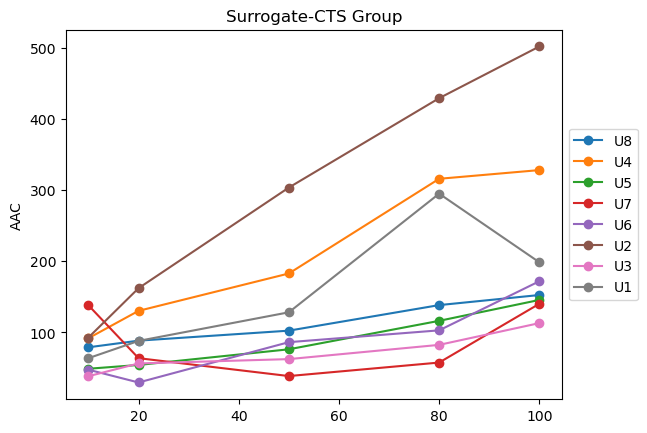

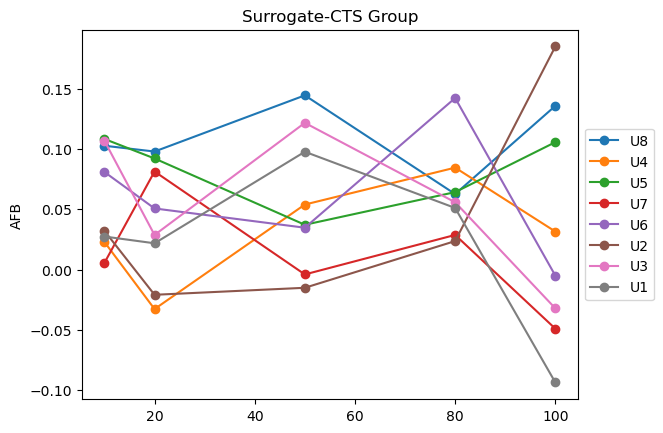

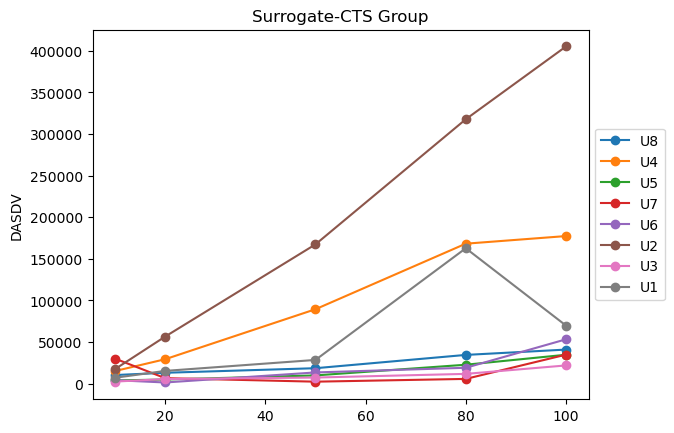

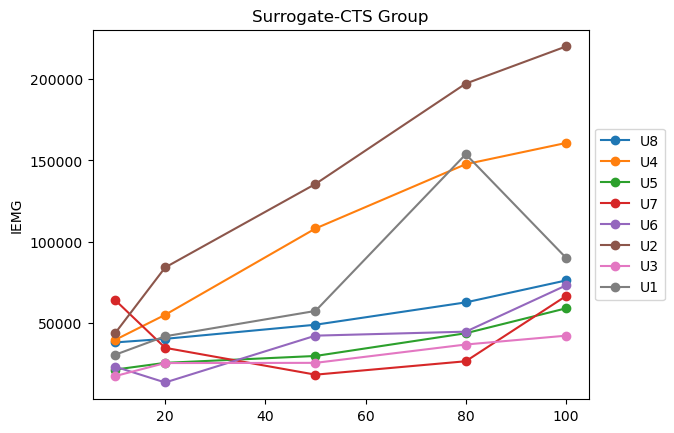

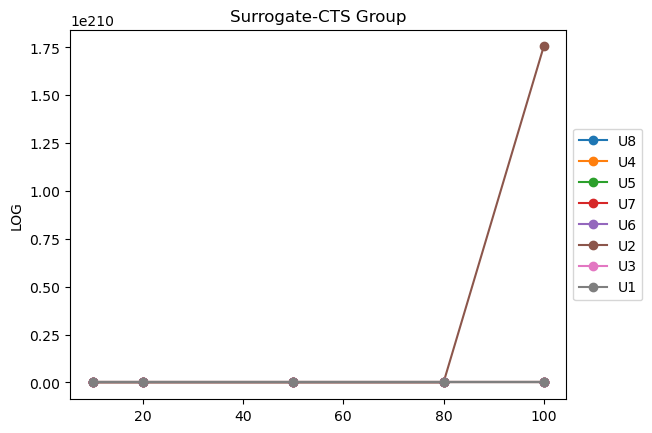

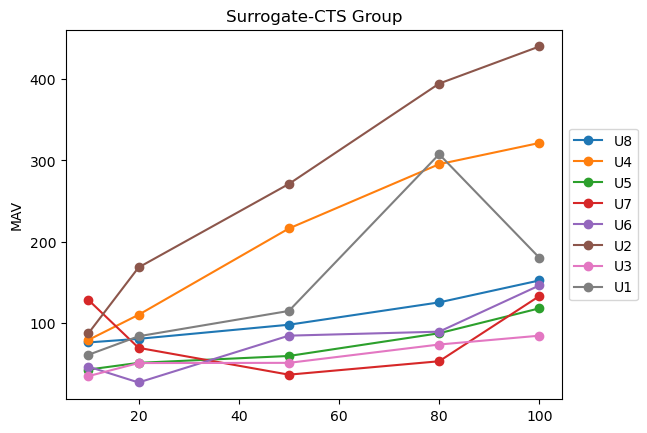

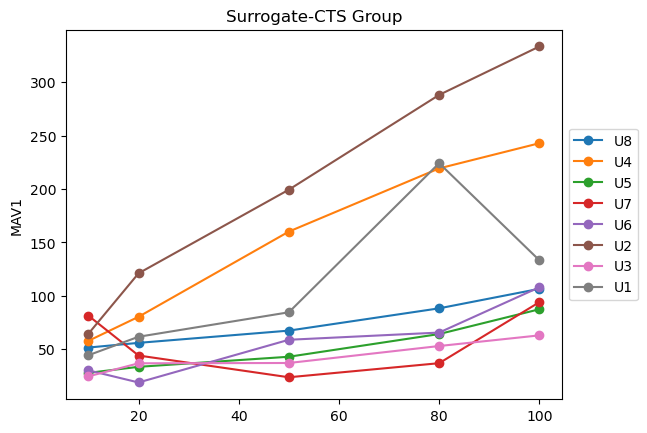

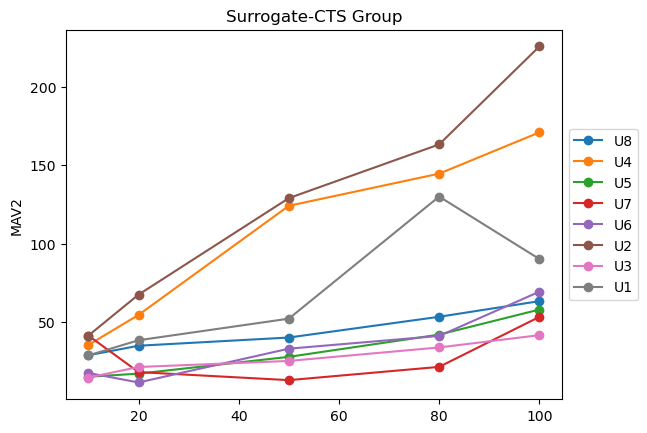

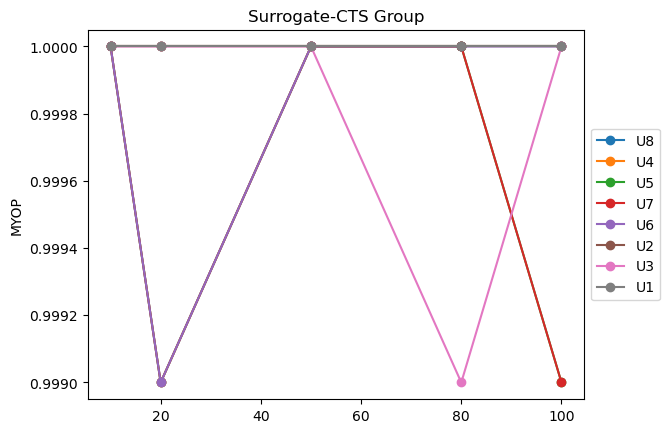

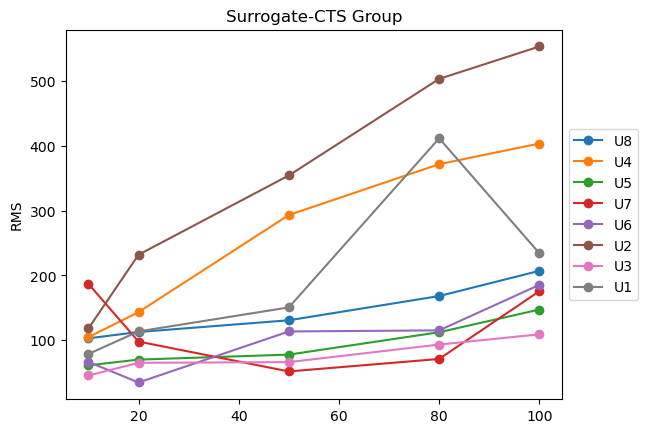

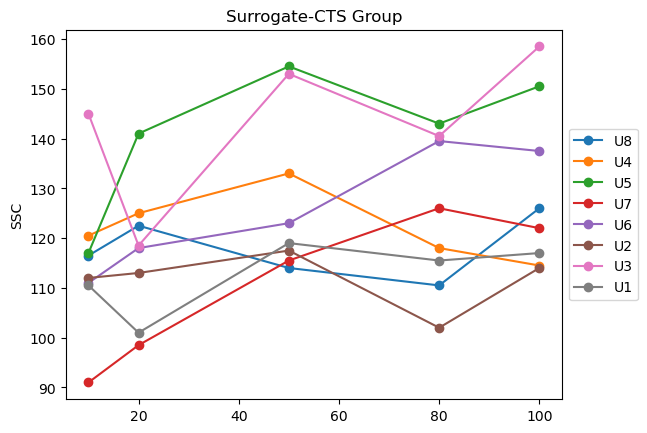

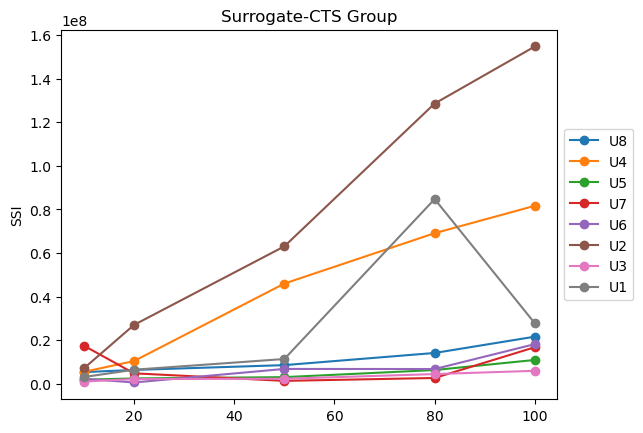

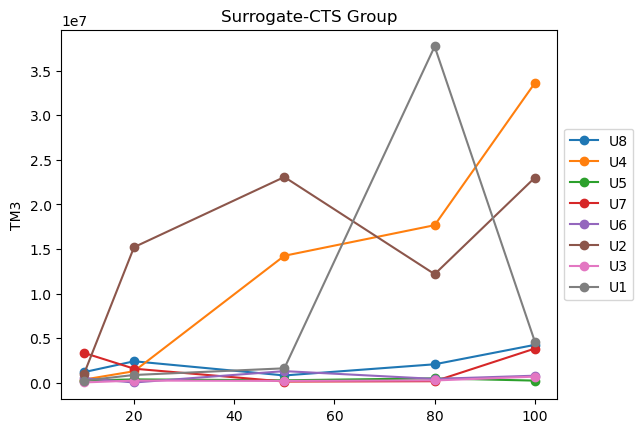

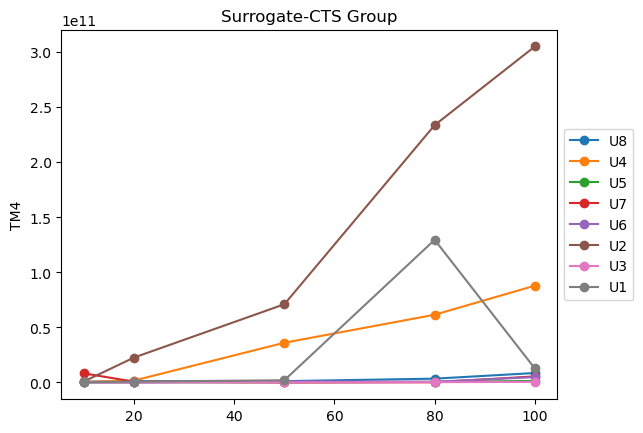

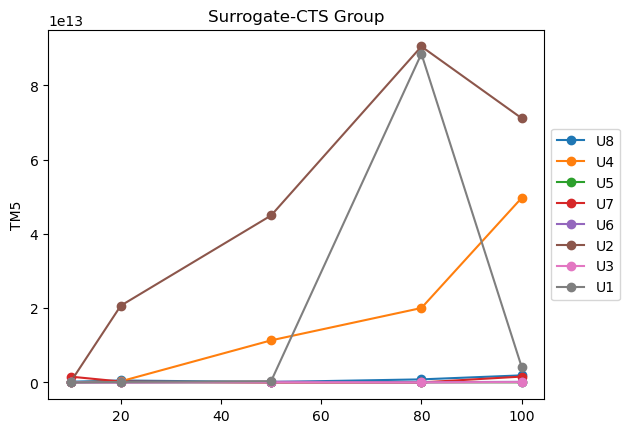

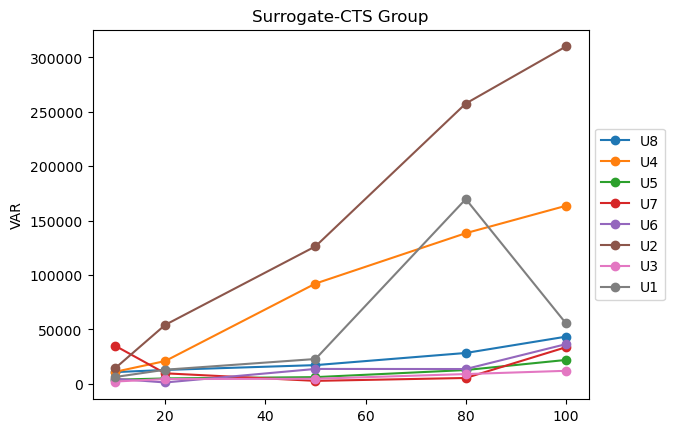

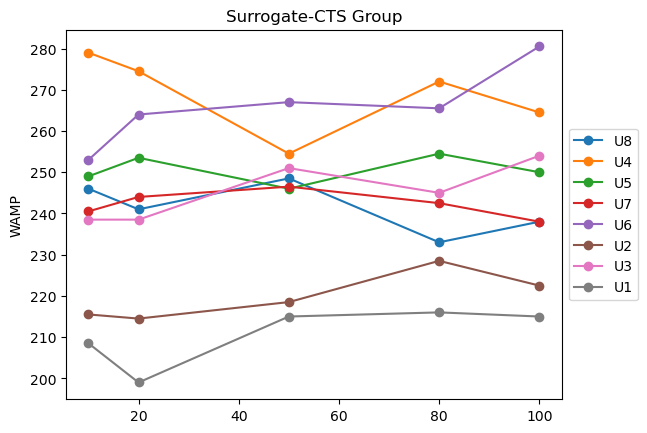

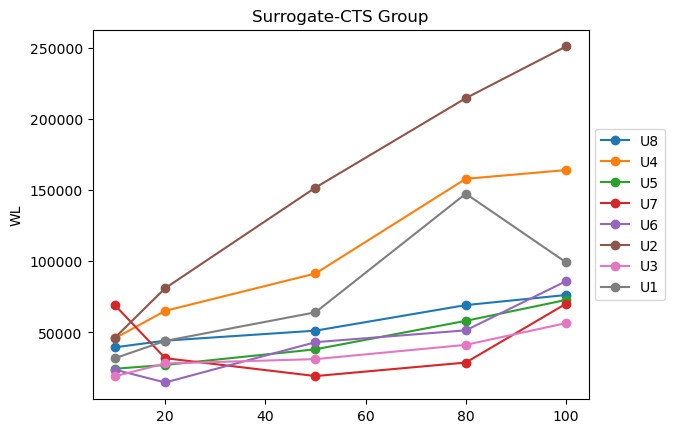

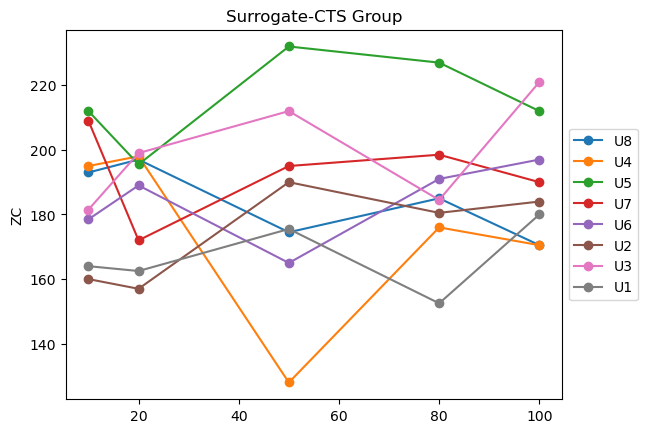

In [149]:
## Frequency domain G50
data_dir = './openbci-data/results/g50/td/'

df_list = []
exp_list = []
for subdir, dirs, files in os.walk(data_dir):
    for file in files: 
        if os.path.join(subdir, file).endswith('csv') and 'td' in file:
            df = pd.read_csv(os.path.join(subdir, file)) 
            df_list.append(df)
            exp_list.append(file[:-4]) 

print(exp_list)

mvc_perc = [10, 20, 50, 80, 100]

cols = df_list[0].columns.difference(['File'])
for col in cols: 
    plt.figure()
    for i,df in enumerate(df_list): 
        plt.plot(mvc_perc, df[col].tolist(), marker='o', label=exp_list[i][-2:]) 
    plt.ylabel(col)
    plt.title("Surrogate-CTS Group")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

['fd_U6', 'fd_U7', 'fd_U5', 'fd_U4', 'fd_U1', 'fd_U3', 'fd_U2', 'fd_U8']


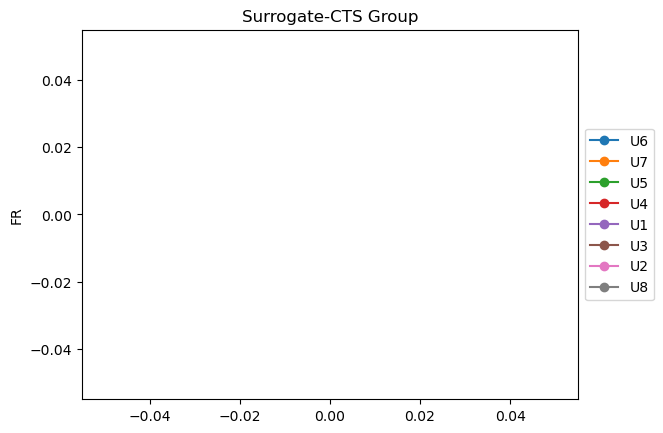

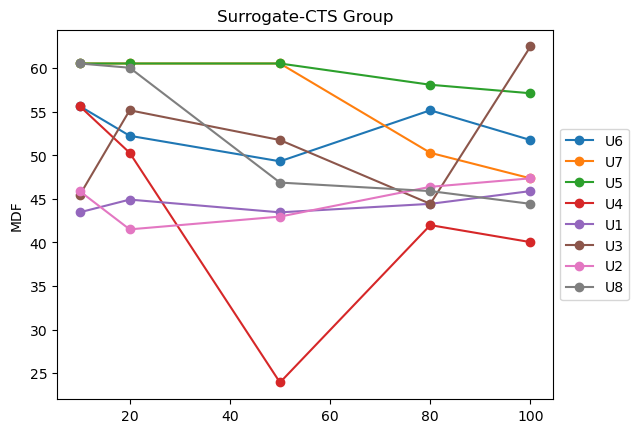

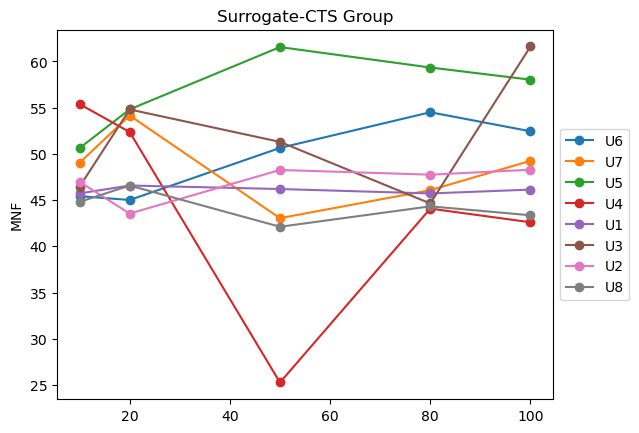

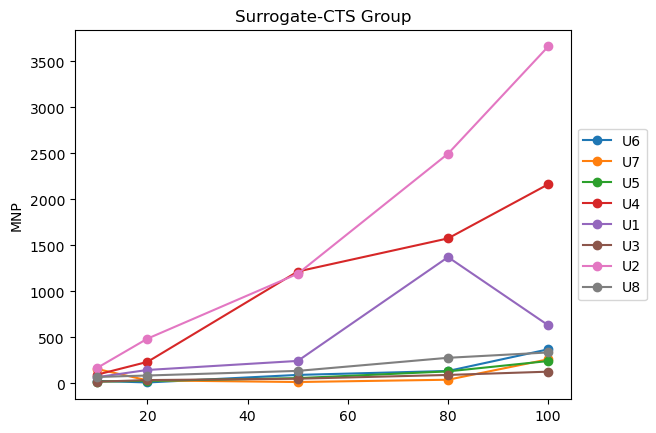

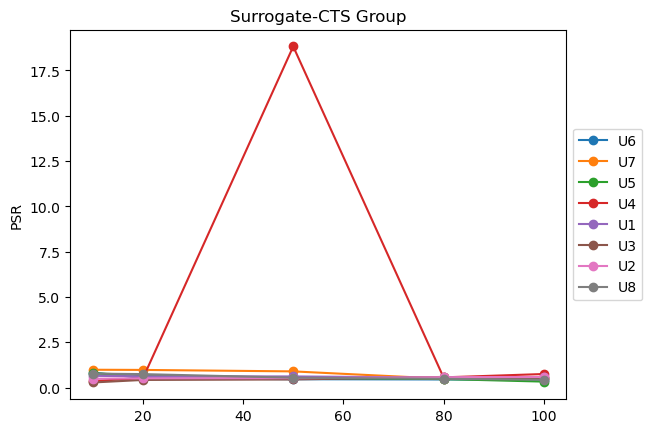

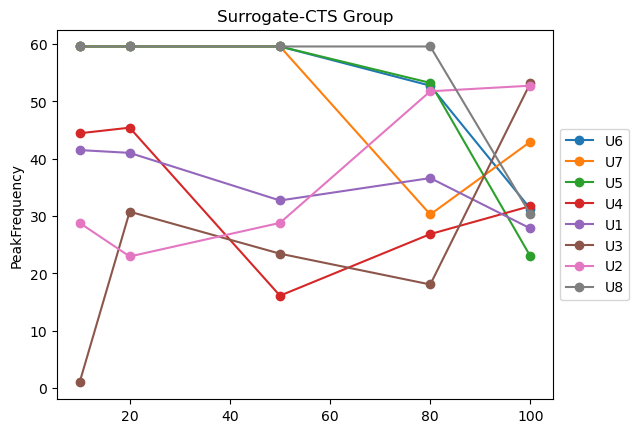

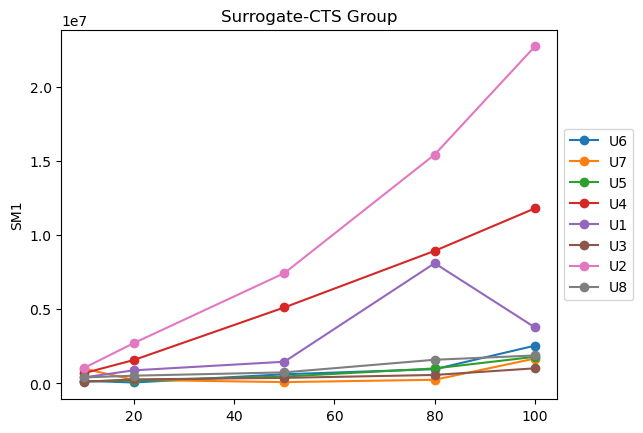

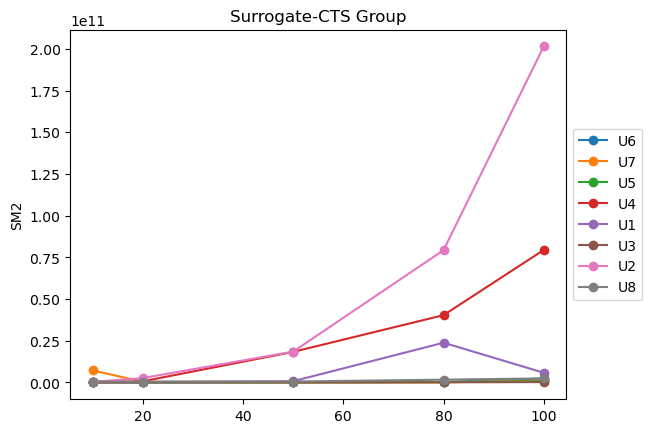

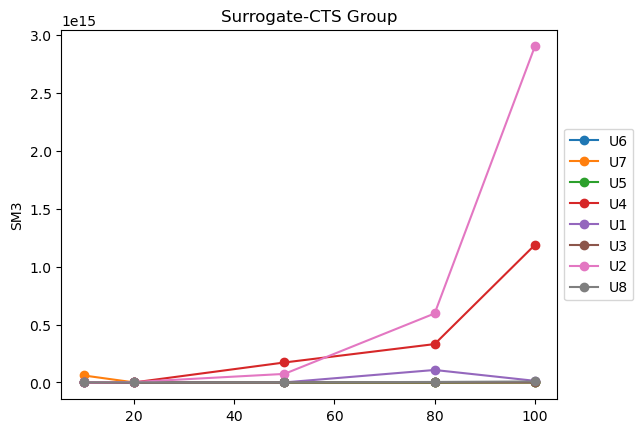

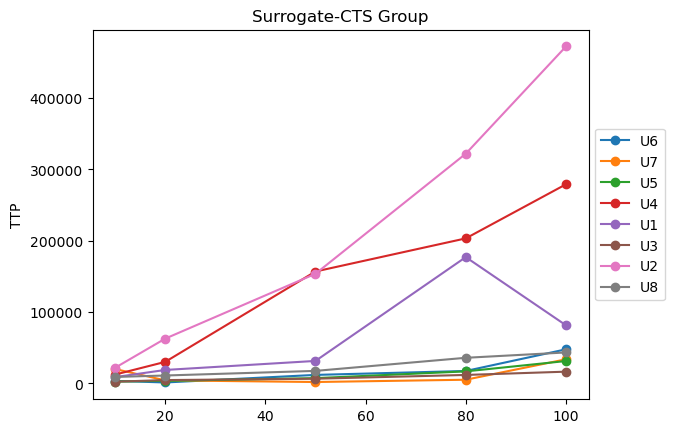

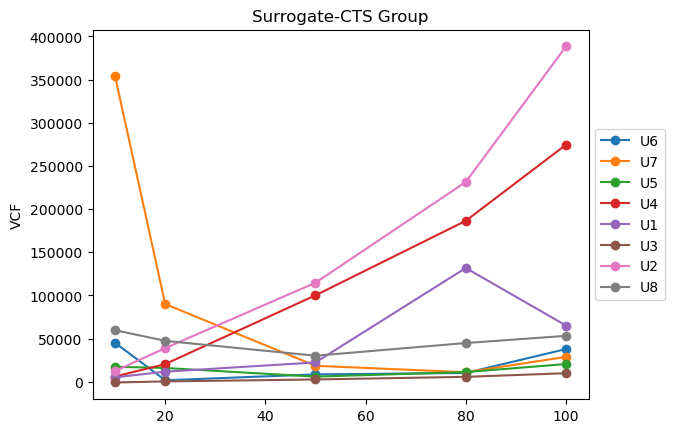

In [150]:
## Frequency domain G50
data_dir = './openbci-data/results/g50/fd/'

df_list = []
exp_list = []
for subdir, dirs, files in os.walk(data_dir):
    for file in files: 
        if os.path.join(subdir, file).endswith('csv') and 'fd' in file:
            df = pd.read_csv(os.path.join(subdir, file)) 
            df_list.append(df)
            exp_list.append(file[:-4]) 

print(exp_list)

mvc_perc = [10, 20, 50, 80, 100]

cols = df_list[0].columns.difference(['File'])
for col in cols: 
    plt.figure()
    for i,df in enumerate(df_list): 
        plt.plot(mvc_perc, df[col].tolist(), marker='o', label=exp_list[i][-2:]) 
    plt.ylabel(col)
    plt.title("Surrogate-CTS Group")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

## To-do: 
Get some more plots: 
- 1) individual user group data (u1-8 as individual series to show variations within a group), DONE
- 2) individual raw data plot to verify cleaning successful. 
- 3) calculation of statistical signficance 